In [15]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random
import sys
from collections import defaultdict

Q(st, at) ← Q(st, at) + α [ rt+1 + γ max Q(st+1, at)) ]

In [16]:
environment = gym.make('Blackjack-v0')

In [17]:
def epsilon_greedy(q_table, epsilon, nA):
    def policy_fn(observation):
        action_policy = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(q_table[observation])
        action_policy[best_action] += (1 - epsilon)
        return action_policy

    return policy_fn

In [18]:
def Q_learning(environment, test_episodes, episodes=500, gamma=1.0, alpha=0.5, epsilon=0.1):

    q_table = defaultdict(lambda: np.zeros(environment.action_space.n))
    
    policy = epsilon_greedy(q_table, epsilon, environment.action_space.n)

    for i in range(episodes):
        if (i + 1) % 100 == 0:
            print("\rEpisode {}/{} ".format(i + 1, episodes), end="")
            sys.stdout.flush()
        state = environment.reset()
        while True:
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = environment.step(action)
            next_action = np.argmax(q_table[next_state])
            td_target = reward + gamma * q_table[next_state][next_action]
            td_error = td_target - q_table[state][action]
            q_table[state][action] += alpha * td_error

            if done:
                break

            state = next_state

    policy = epsilon_greedy(q_table, 0, environment.action_space.n)
    win_count = 0
    reward_sum = 0

    for i in range(test_episodes):
        # Reset the environment and pick the first action
        observation = environment.reset()
        state = observation

        while True:
            # Take a step
            action_probs = policy(observation)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

            observation, reward, done, _ = environment.step(action)

            reward_sum += reward

            if reward > 0:
                win_count += 1

            if done:
                break

    print("\nTotal Test Episodes: {}".format(test_episodes))
    print("Win Count: {}".format(win_count))
    print("Reward Sum: {}".format(reward_sum))

    return q_table

In [19]:
def plot_figure(ax, usable_ace):
    def get_action(player_hand, dealer_showing, usable_ace):
        return policy[player_hand, dealer_showing, usable_ace] if (player_hand, dealer_showing, usable_ace) in policy else 1

    policy_matrix = np.array([[get_action(player_hand, dealer_showing, usable_ace) for dealer_showing in range(1, 11)]
                           for player_hand in range(21, 10, -1)])

    ax.imshow(policy_matrix, cmap=plt.cm.Accent, extent=[0.5, 10.5, 10.5, 21.5])
    plt.ylim(11, 21)
    plt.xlim(1, 10)
    plt.xlabel('Dealer Hand')
    plt.ylabel('Player Hand')
    hit_patch = mpatches.Patch(color=plt.cm.Accent(.1), label='Stick')
    stick_patch = mpatches.Patch(color=plt.cm.Accent(.9), label='Hit')
    plt.legend(handles=[hit_patch, stick_patch])


Episode 1000/1000 
Total Test Episodes: 1000
Win Count: 374
Reward Sum: -170.0


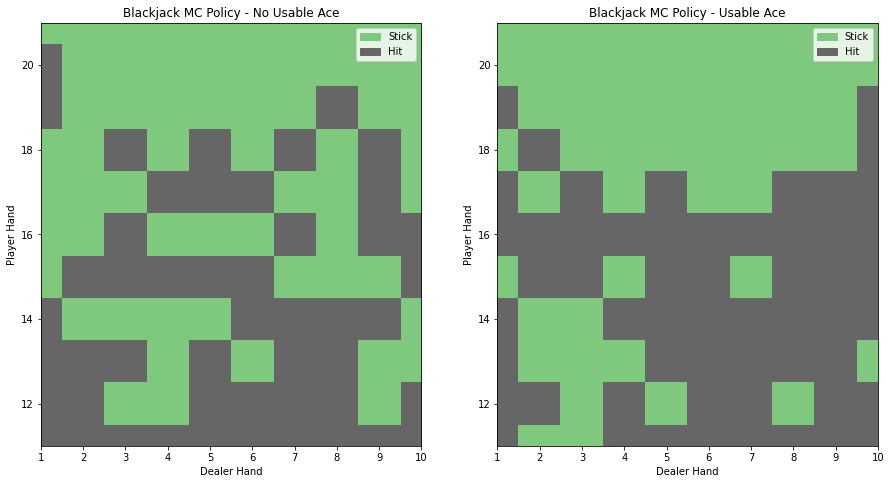

In [20]:
q_table = Q_learning(environment, 1000, 1000)
policy = dict((k, np.argmax(v)) for k, v in q_table.items())

figure = plt.figure(figsize=(15, 15))
ax = figure.add_subplot(121)
ax.set_title('Blackjack MC Policy - No Usable Ace')
plot_figure(ax, True)
ax = figure.add_subplot(122)
ax.set_title('Blackjack MC Policy - Usable Ace')
plot_figure(ax, False)
plt.show()